In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


This is the first dataset out of 5 datasets for training.  
In this 1st dataset, we have 200 csv files each correspond to one flight instance ( A trip from one source to destination ). 

In each csv file (flight instance), we have around 7000-11000 data points corresponding to sensor data recorded at each second  

The process of analysing the data is as follows : 
1) Observe and analyse the individual dataset (First flight instance)  
2) Observe and analyse the combined dataset ( All flight instances together )  
3) Observe each Phase (Preflight, takeoff, cruise...) individually dividing the combined dataset into phase wise datasets

# Initial Setup

In [3]:
path = "/kaggle/input/airplane-train-data-1/CAX_Train_1"
files = os.listdir(path)

In [4]:
# combining all dataframes together
set_of_all_dataframes = [pd.read_csv(os.path.join(path,file))  for file in files]
first_instance = set_of_all_dataframes[0]
combined_df = pd.concat(set_of_all_dataframes, ignore_index = True)

In [5]:
combined_df.head()

,ACID,Flight_instance_ID,Year,Month,Day,Hour,Minute,Second,ABRK,ELEV_1,...,BPGR_2,BPYR_1,BPYR_2,CALT,CASS,CRSS,DFGS,DWPT,EAI,FF
0,676,676200408180742,2004,8,18,7,41,36,83.890884,-0.595299,...,19.5313,48.828247,0.0,0,131.0,-158.026213,1,27840,0,0
1,676,676200408180742,2004,8,18,7,41,37,83.876236,-0.574841,...,19.5313,48.828247,0.0,0,131.0,-158.026213,1,27840,0,0
2,676,676200408180742,2004,8,18,7,41,38,83.876236,-0.574841,...,19.5313,48.828247,0.0,0,131.0,-158.026213,1,27840,0,0
3,676,676200408180742,2004,8,18,7,41,39,83.876236,-0.595299,...,19.5313,48.828247,0.0,0,131.0,-158.026213,1,27840,0,0
4,676,676200408180742,2004,8,18,7,41,40,83.876236,-0.595299,...,19.5313,48.828247,0.0,0,131.0,-158.026213,1,27840,0,0


In [6]:
combined_df.shape

(1074612, 226)

In [7]:
first_instance.head()

,ACID,Flight_instance_ID,Year,Month,Day,Hour,Minute,Second,ABRK,ELEV_1,...,BPGR_2,BPYR_1,BPYR_2,CALT,CASS,CRSS,DFGS,DWPT,EAI,FF
0,676,676200408180742,2004,8,18,7,41,36,83.890884,-0.595299,...,19.5313,48.828247,0,0,131.0,-158.026213,1,27840,0,0
1,676,676200408180742,2004,8,18,7,41,37,83.876236,-0.574841,...,19.5313,48.828247,0,0,131.0,-158.026213,1,27840,0,0
2,676,676200408180742,2004,8,18,7,41,38,83.876236,-0.574841,...,19.5313,48.828247,0,0,131.0,-158.026213,1,27840,0,0
3,676,676200408180742,2004,8,18,7,41,39,83.876236,-0.595299,...,19.5313,48.828247,0,0,131.0,-158.026213,1,27840,0,0
4,676,676200408180742,2004,8,18,7,41,40,83.876236,-0.595299,...,19.5313,48.828247,0,0,131.0,-158.026213,1,27840,0,0


In [8]:
first_instance.shape

(7080, 226)

In [9]:
# adding time stamp to combined dataset
combined_df['Timestamp'] = pd.to_datetime(combined_df[['Year','Month','Day','Hour','Minute','Second']])

# adding time stamp to all individual dataframes
for df in set_of_all_dataframes:
    df['Timestamp'] = pd.to_datetime(df[['Year','Month','Day','Hour','Minute','Second']])

In [10]:
def drop_unnecessary_columns(df):
    df.drop(columns = ['Year','Month','Hour','Minute','Second'],inplace = True)
    numeric_columns = df.select_dtypes(include = ['int64','float64']).columns
    var_0_columns = [column for column in numeric_columns if df[column].var()==0 and column != 'Flight_instance_ID']
    df.drop(columns = var_0_columns,inplace = True)
    return df

In [11]:
# cleaning all individual dataframes
for i in range(len(set_of_all_dataframes)):
    set_of_all_dataframes[i] = drop_unnecessary_columns(set_of_all_dataframes[i])

# cleaning combined dataframe
combined_df = drop_unnecessary_columns(combined_df)

## Available features and their description

* ACID: Aircraft identification or registration number.

* Flight_instance_ID: Unique identifier for each flight instance or record.

* Year, Month, Day, Hour, Minute, Second: Timestamp information for the flight event.

* ABRK: Represents the status of the autobrake system (e.g., Armed or Disarmed).

* ELEV_1, ELEV_2: Elevation information from two different sensors or sources.

* EVNT: Records specific events or incidents during the flight.

* FADF, FADS, FGC3: Different sensors or systems related to flight data and control.

* FIRE_1, FIRE_2, FIRE_3, FIRE_4: Fire-related sensors or indicators from different locations on the aircraft.

* FLAP: Indicates the position of the aircraft's flaps during the flight.

* FQTY_1, FQTY_2, FQTY_3, FQTY_4: Fuel quantity measurements from different fuel tanks.

* GLS, GPWS, HDGS, HF1, HF2, HYDG, HYDY, ILSF, LATP, LMOD, LOC, LONP: Various sensors or systems related to flight navigation and control.

* MNS, MRK, MW: Miscellaneous data points or measurements.

* N1CO, OIPL, OIT_1, OIT_2, OIT_3, OIT_4: Engine and oil temperature-related data.

* PACK, PH, POVT, PTRM, PUSH, SAT, SMKB, SMOK, SNAP, SPLG, SPLY, SPL_1, SPL_2, TAI, TAT, TCAS, TMAG, TMODE: Various aircraft systems or indicators.

* VHF1, VHF2, VHF3, VMODE, VSPS, WAI_1, WAI_2: Communication and weather-related data.

* APUF_Mean, APUF_Min, APUF_Max: Mean, Minimum, and Maximum values of certain parameters (e.g., Air Pressure Under Fuselage).

* CCPC_Mean, CCPC_Min, CCPC_Max, CCPF_Mean, CCPF_Min, CCPF_Max, CWPC_Mean, CWPC_Min, CWPC_Max, CWPF_Mean, CWPF_Min, CWPF_Max: Mean, Minimum, and Maximum values for different parameters related to the aircraft's systems or performance.

* MSQT_1_Mean, MSQT_1_Min, MSQT_1_Max, MSQT_2_Mean, MSQT_2_Min, MSQT_2_Max: Mean, Minimum, and Maximum values for various measurements (e.g., Mean Squared Quiver 1, 2).

* PI_Mean, PI_Min, PI_Max, PS_Mean, PS_Min, PS_Max, PSA_Mean, PSA_Min, PSA_Max, PT_Mean, PT_Min, PT_Max: Mean, Minimum, and Maximum values for different pressure-related parameters.

* RUDD_Mean, RUDD_Min, RUDD_Max, RUDP_Mean, RUDP_Min, RUDP_Max, SHKR_Mean, SHKR_Min, SHKR_Max: Mean, Minimum, and Maximum values for various sensor data (e.g., Rudder, Rudd Pedal).

* TOCW_Mean, TOCW_Min, TOCW_Max: Mean, Minimum, and Maximum values for Takeoff Configuration Warning data.

* ALT_Mean, ALT_Min, ALT_Max, ALTR_Mean, ALTR_Min, ALTR_Max: Mean, Minimum, and Maximum values for altitude-related parameters.

* AOA1_Mean, AOA1_Min, AOA1_Max, AOA2_Mean, AOA2_Min, AOA2_Max, AOAC_Mean, AOAC_Min, AOAC_Max, AOAI_Mean, AOAI_Min, AOAI_Max: Mean, Minimum, and Maximum values for Angle of Attack and related measurements.

* BAL1_Mean, BAL1_Min, BAL1_Max, BAL2_Mean, BAL2_Min, BAL2_Max: Mean, Minimum, and Maximum values for balance-related data.

* CAS_Mean, CAS_Min, CAS_Max, CASM_Mean, CASM_Min, CASM_Max: Mean, Minimum, and Maximum values for calibrated airspeed measurements.

* DA_Mean, DA_Min, DA_Max, GS_Mean, GS_Min, GS_Max, LATG_Mean, LATG_Min, LATG_Max, LONG_Mean, LONG_Min, LONG_Max: Mean, Minimum, and Maximum values for various measurements related to aircraft navigation and performance.

* MACH_Mean, MACH_Min, MACH_Max, MH_Mean, MH_Min, MH_Max, N1T_Mean, N1T_Min, N1T_Max: Mean, Minimum, and Maximum values for Mach number, magnetic heading, and other parameters.

* NSQT_Mean, NSQT_Min, NSQT_Max, TAS_Mean, TAS_Min, TAS_Max, TH_Mean, TH_Min, TH_Max, TRK_Mean, TRK_Min, TRK_Max, TRKM_Mean, TRKM_Min, TRKM_Max: Mean, Minimum, and Maximum values for various speed, temperature, and tracking measurements.

* VIB_1_Mean, VIB_1_Min, VIB_1_Max: Mean, Minimum, and Maximum values for vibration-related data.

* WD_Mean, WD_Min, WD_Max, WS_Mean, WS_Min, WS_Max: Mean, Minimum, and Maximum values for wind direction and speed.

* RALT_Mean, RALT_Min, RALT_Max, ROLL_Mean, ROLL_Min, ROLL_Max, VRTG_Mean, VRTG_Min, VRTG_Max: Mean, Minimum, and Maximum values for various measurements related to altitude, roll, and vertical acceleration.

* CTAC_Mean, CTAC_Min, CTAC_Max, FPAC_Mean, FPAC_Min, FPAC_Max, IVV_Mean, IVV_Min, IVV_Max: Mean, Minimum, and Maximum values for various parameters related to aircraft control and performance.

* ACMT, AIL_1, AIL_2, ALTS, APFD, A_T, BLV, BPGR_1, BPGR_2, BPYR_1, BPYR_2, CALT, CASS, CRSS, DFGS, DWPT, EAI, FF: Miscellaneous data points or measurements.

## Phases representation

* 0 = Unknown
* 1 = Preflight
* 2 = Taxi
* 3 = Takeoff
* 4 = Climb
* 5 = Cruise
* 6 = Approach
* 7 = Rollout


In [12]:
phases = ['unknown','preflight','taxi','takeoff','climb','cruise','approach','rollout']
phase_encodings = {0:'unknown', 1:'preflight', 2:'taxi', 3:'takeoff', 4:'climb', 5:'cruise',6:'approach', 7:'rollout'}
phase_encodings

{0: 'unknown',
 1: 'preflight',
 2: 'taxi',
 3: 'takeoff',
 4: 'climb',
 5: 'cruise',
 6: 'approach',
 7: 'rollout'}

# Individual flight instance analysis

In [13]:
first_instance.head()

,Flight_instance_ID,ABRK,ELEV_1,ELEV_2,FGC3,FLAP,FQTY_1,FQTY_2,FQTY_4,GLS,...,APFD,BLV,BPGR_2,BPYR_1,CASS,CRSS,DWPT,EAI,FF,Timestamp
0,676200408180742,83.890884,-0.595299,42.656948,120,95,8016,3272,8040,0.10764,...,2,0,19.5313,48.828247,131.0,-158.026213,27840,0,0,2004-08-18 07:41:36
1,676200408180742,83.876236,-0.574841,42.656948,120,95,8016,3264,8040,0.10842,...,2,0,19.5313,48.828247,131.0,-158.026213,27840,0,0,2004-08-18 07:41:37
2,676200408180742,83.876236,-0.574841,42.656948,120,94,8016,3272,8040,0.08853,...,2,0,19.5313,48.828247,131.0,-158.026213,27840,0,0,2004-08-18 07:41:38
3,676200408180742,83.876236,-0.595299,42.656948,120,94,8016,3264,8040,0.25545,...,2,0,19.5313,48.828247,131.0,-158.026213,27840,0,0,2004-08-18 07:41:39
4,676200408180742,83.876236,-0.595299,42.656948,120,94,8016,3272,8040,0.11037,...,2,0,19.5313,48.828247,131.0,-158.026213,27840,0,0,2004-08-18 07:41:40


In [14]:
first_instance.shape

(7080, 189)

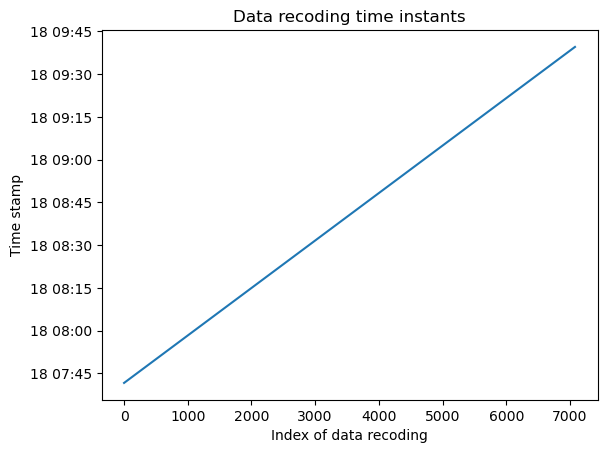

In [15]:
plt.plot(first_instance['Timestamp'])
plt.title("Data recoding time instants")
plt.xlabel("Index of data recoding")
plt.ylabel("Time stamp")
plt.show()

In [17]:
first_instance['Timestamp'].min(), first_instance['Timestamp'].max()

(Timestamp('2004-08-18 07:41:36'), Timestamp('2004-08-18 09:39:35'))

In [18]:
first_instance['Flight_instance_ID'].min(), first_instance['Flight_instance_ID'].max(), first_instance['Flight_instance_ID'].var()

(676200408180742, 676200408180742, 0.01562720723265998)

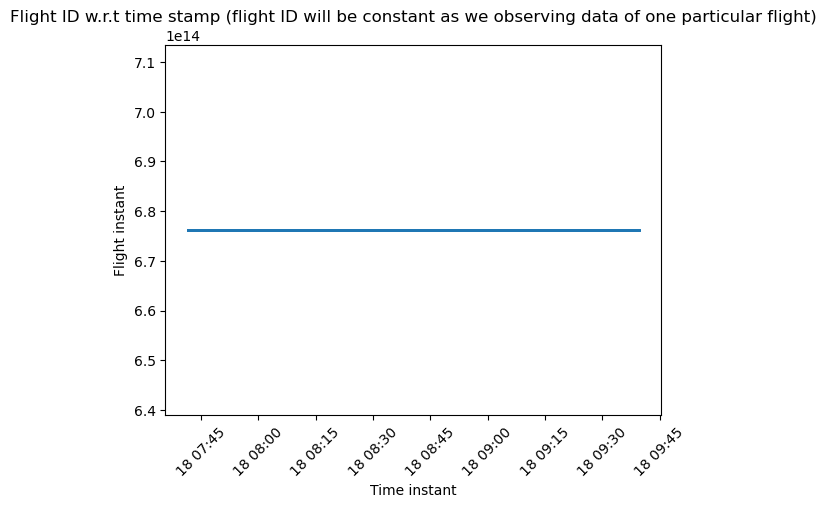

In [19]:
plt.scatter(first_instance['Timestamp'], first_instance['Flight_instance_ID'], s=1)
plt.xlabel("Time instant")
plt.ylabel("Flight instant")
plt.title("Flight ID w.r.t time stamp (flight ID will be constant as we observing data of one particular flight)")
plt.xticks(rotation=45)
plt.show()

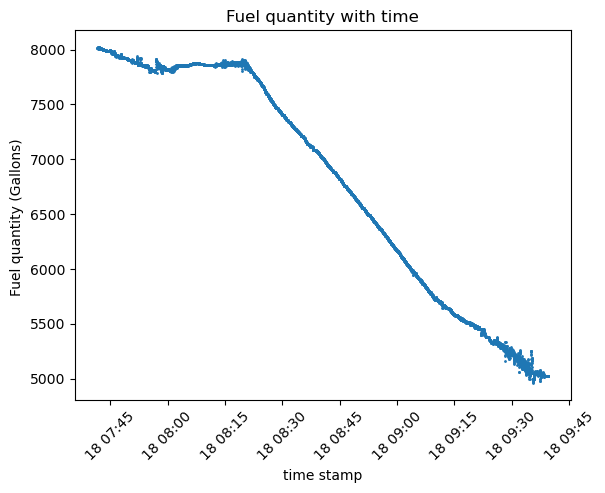

In [20]:
plt.scatter(first_instance['Timestamp'], first_instance['FQTY_1'], s=1)
plt.title("Fuel quantity with time")
plt.xlabel("time stamp")
plt.xticks(rotation = 45)
plt.ylabel("Fuel quantity (Gallons) ")
plt.show()

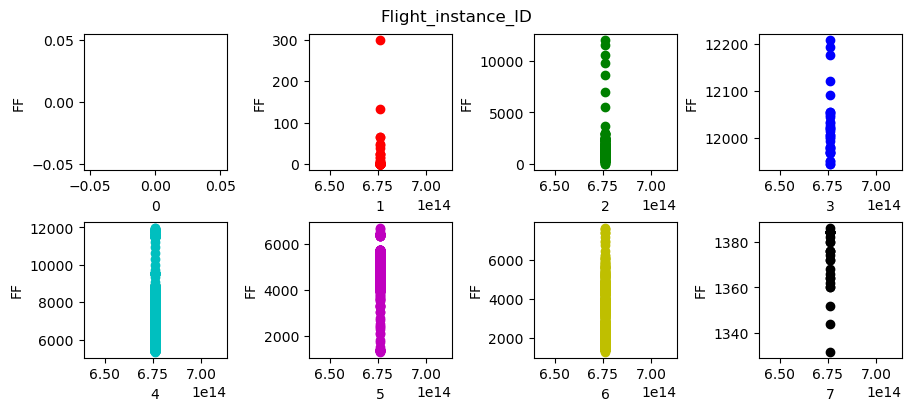

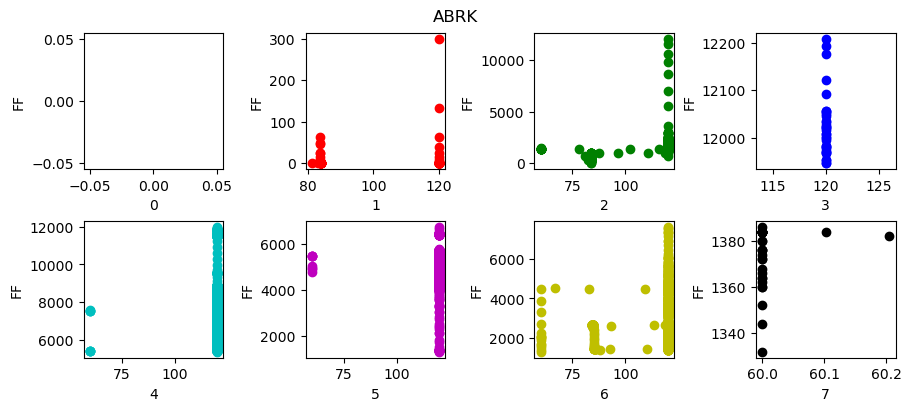

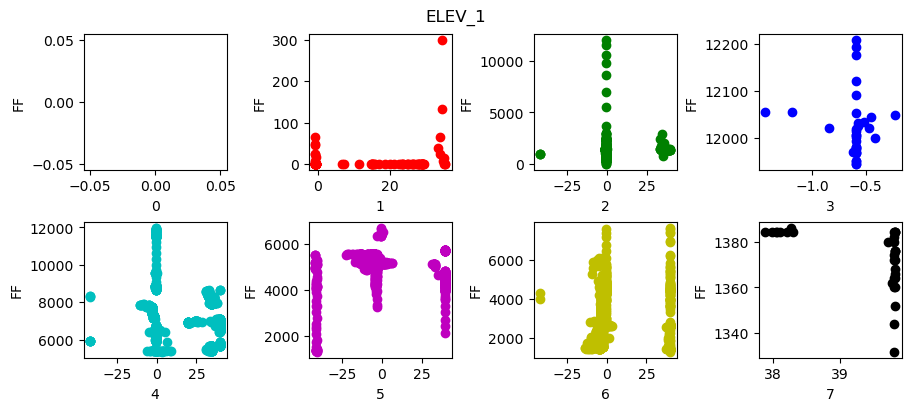

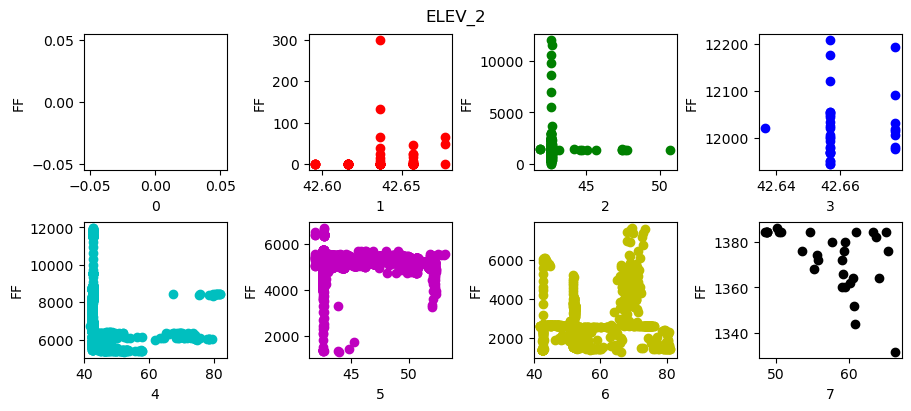

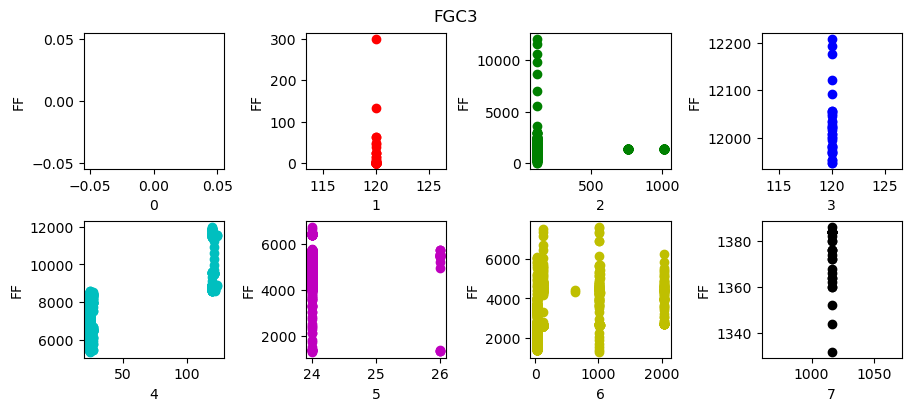

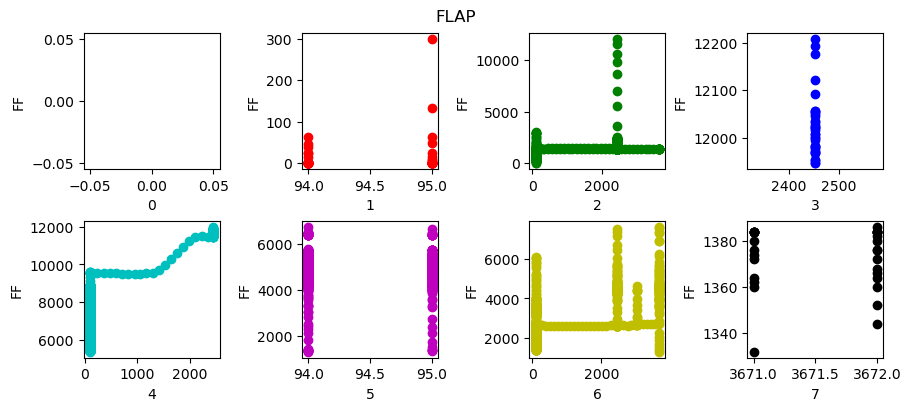

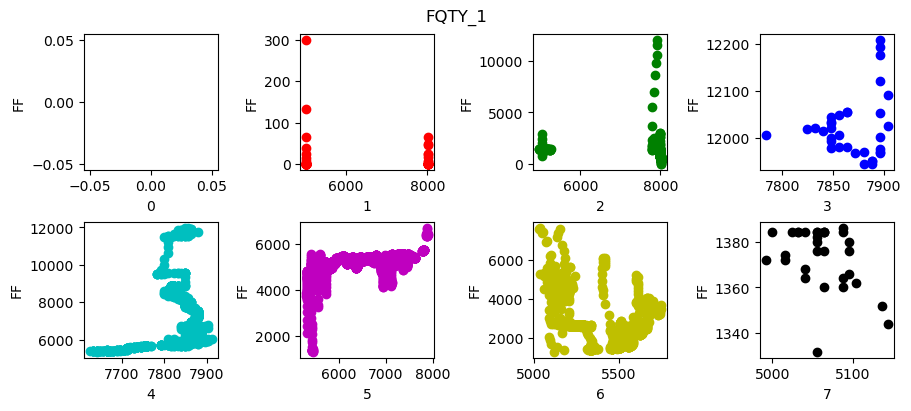

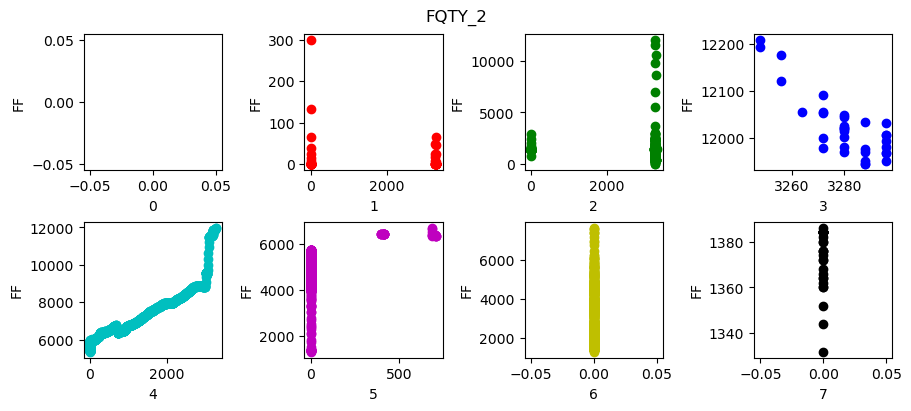

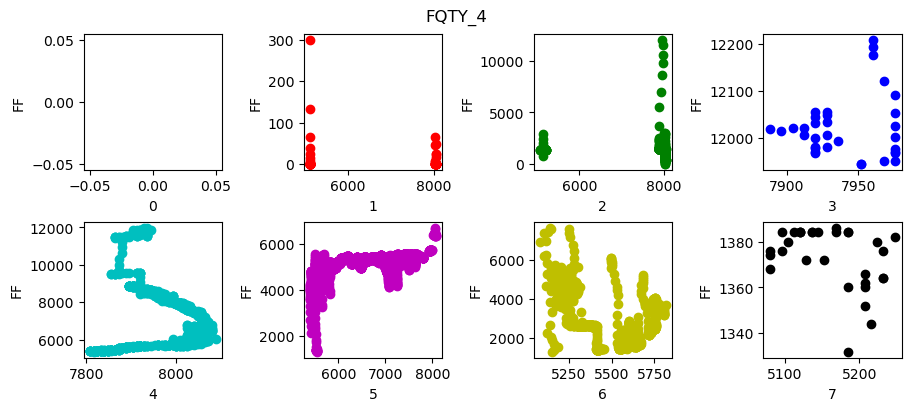

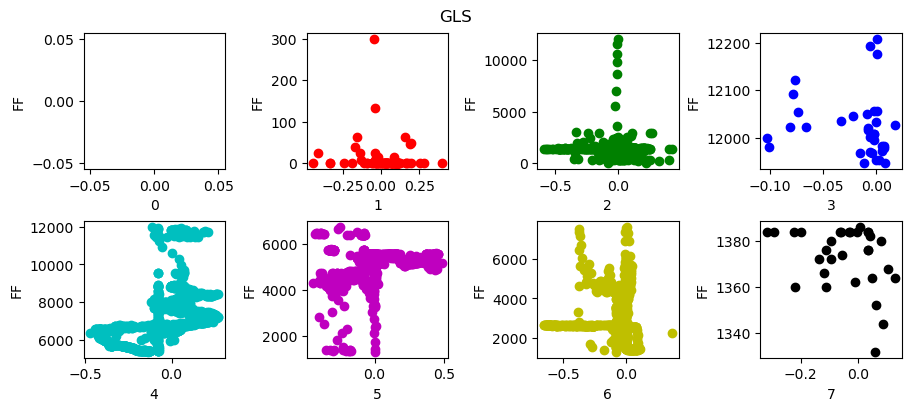

In [21]:
colormap_array = ['orange','r','g','b','c','m','y','k']
ph = first_instance["PH"]

colors = np.array(colormap_array)[ph.astype(int)]

for j in range(10):
    fig, axs = plt.subplots(2, 4, figsize=(9,4),constrained_layout=True)
    col = first_instance.columns[j]
    for i in range(8):
        x = first_instance[first_instance["PH"] == i][col]
        y = first_instance[first_instance["PH"] == i]["FF"]
        axs[int(i/4),i%4].scatter(x,y, c = colormap_array[i])
        axs[int(i/4),i%4].set_xlabel(i)
        axs[int(i/4),i%4].set_ylabel('FF')
        axs[int(i/4),i%4].set

    fig.suptitle(col)
    labels = range(8)
    #fig.legend(axs, labels=labels, loc = "right")

In [22]:
first_instance_unknown     =  first_instance[first_instance['PH']==0] 
first_instance_preflight   =  first_instance[first_instance['PH']==1]
first_instance_taxi        =  first_instance[first_instance['PH']==2]
first_instance_takeoff     =  first_instance[first_instance['PH']==3]
first_instance_climb       =  first_instance[first_instance['PH']==4]
first_instance_cruise      =  first_instance[first_instance['PH']==5]
first_instance_approach    =  first_instance[first_instance['PH']==6]
first_instance_rollout     =  first_instance[first_instance['PH']==7]

### Correlation 

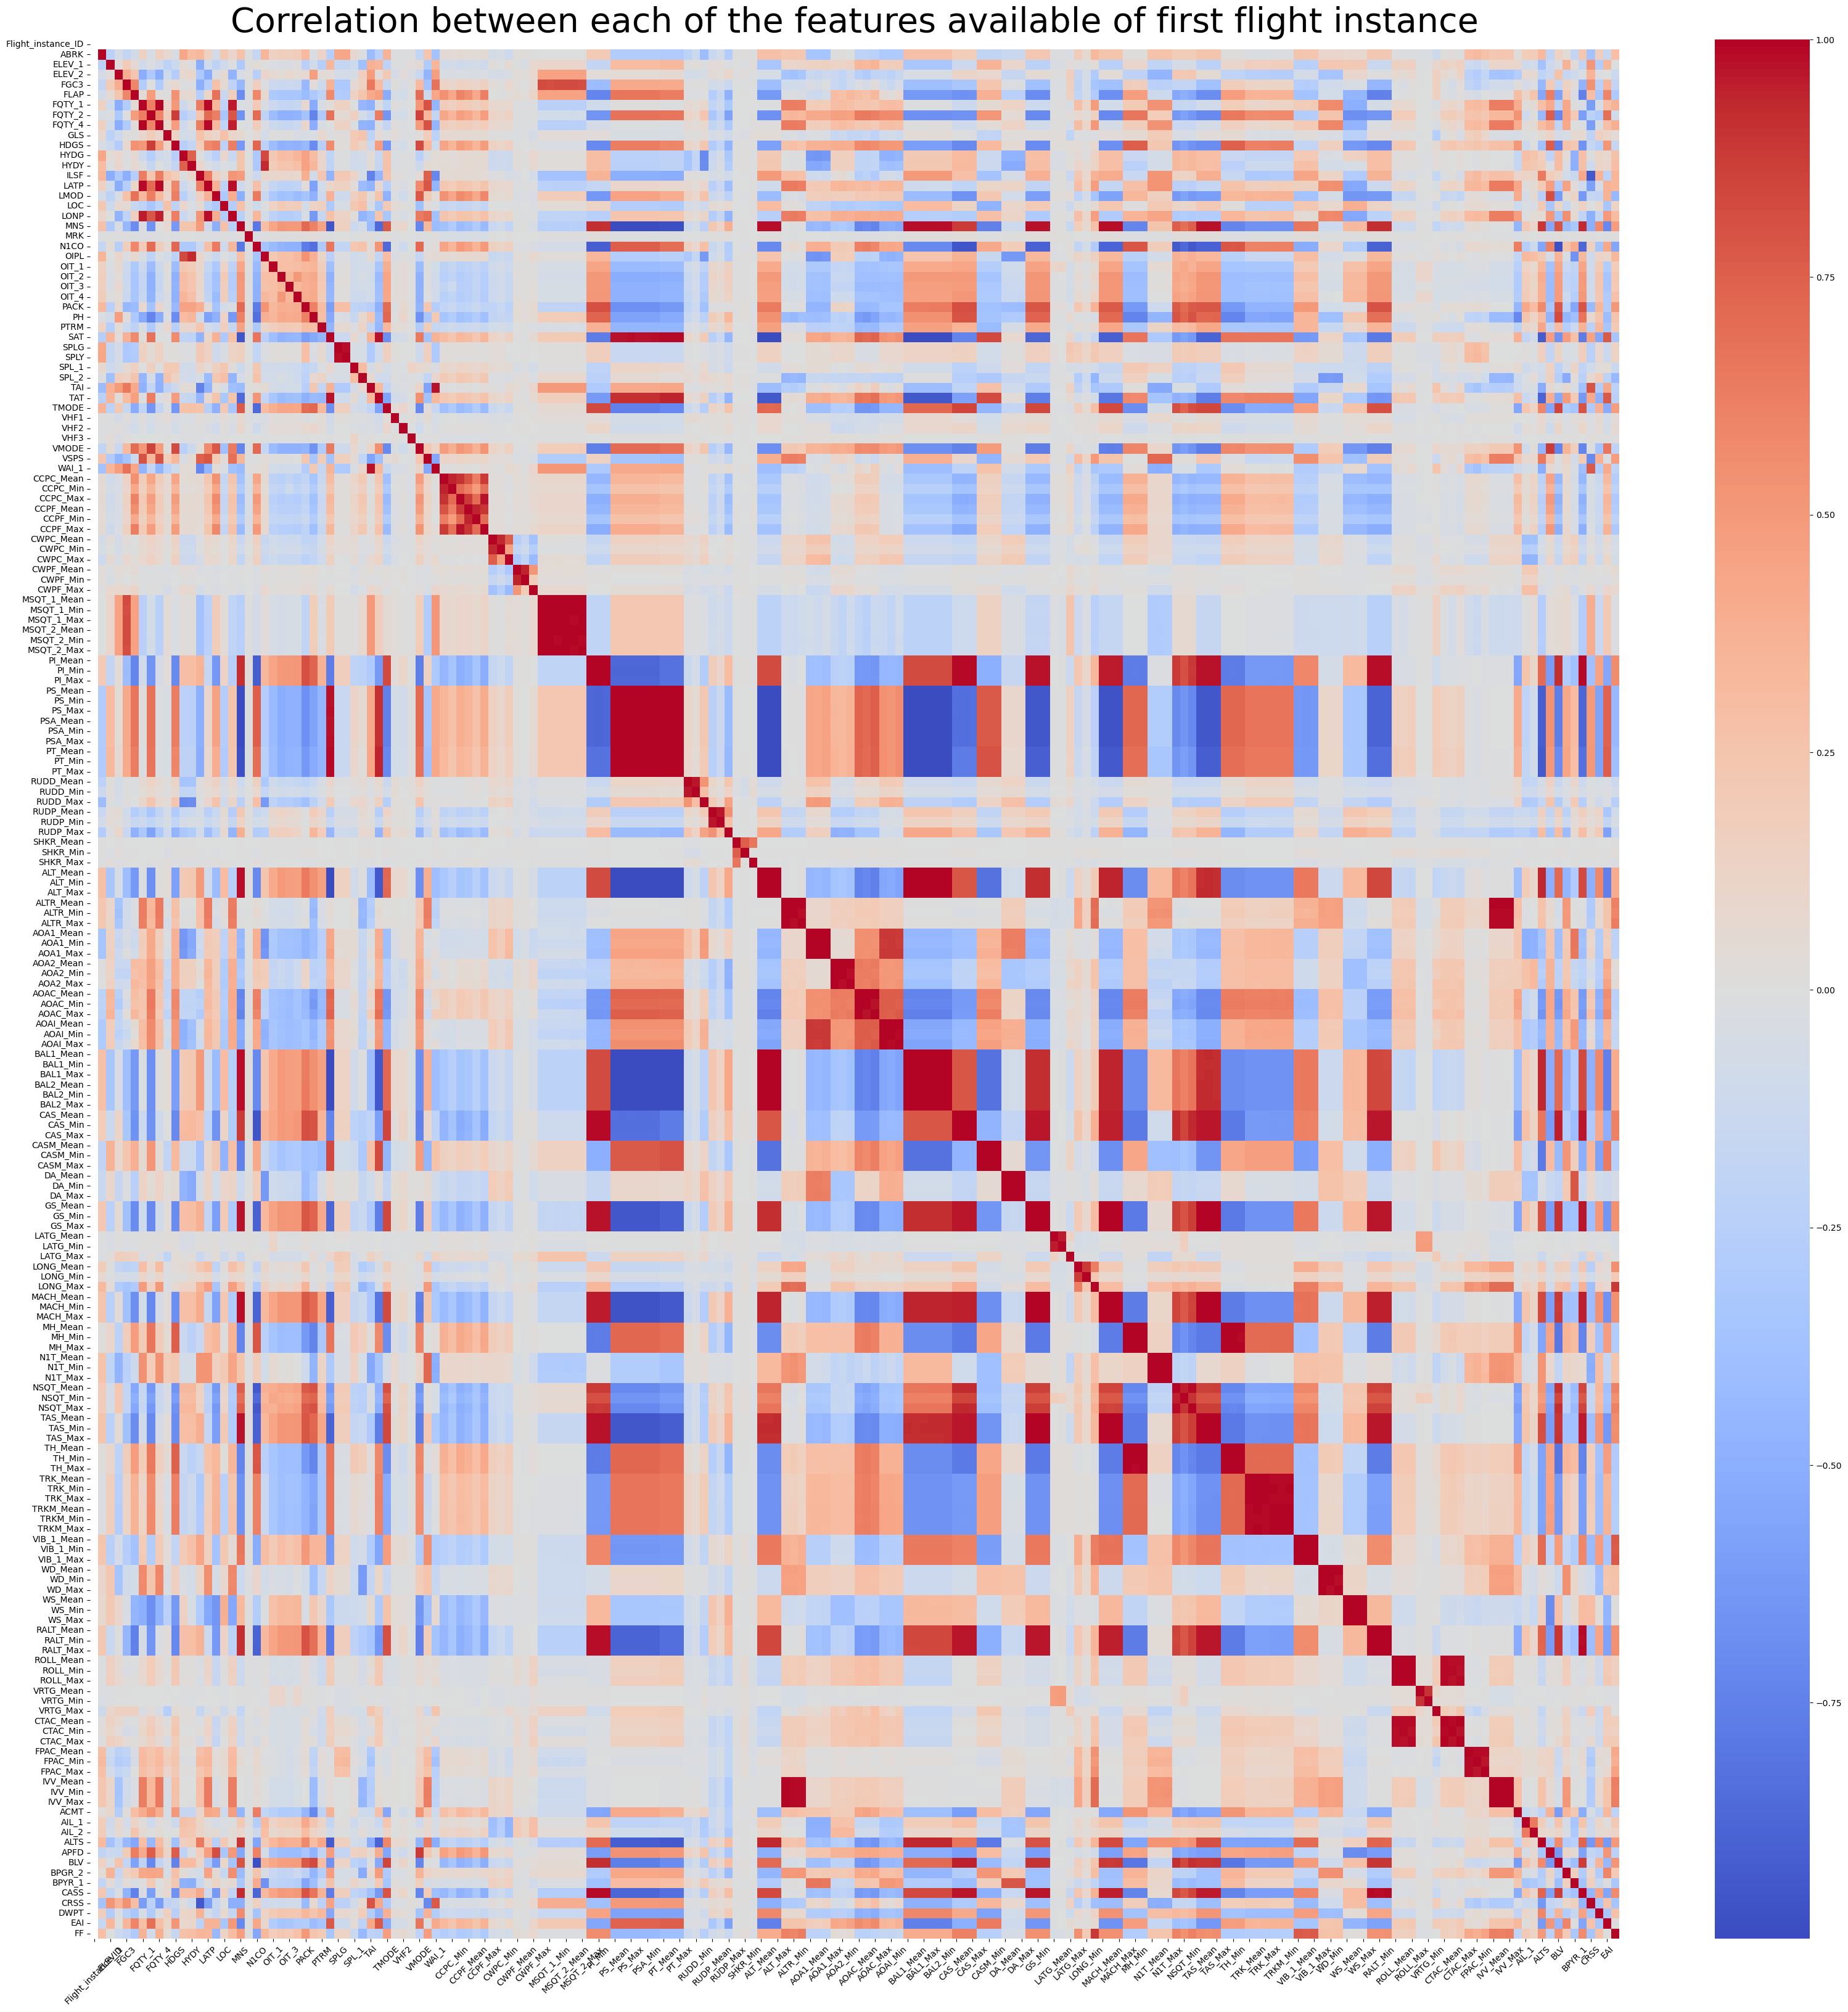

In [68]:
numeric_columns_dataset = first_instance.select_dtypes(include = 'number')
numeric_columns = numeric_columns_dataset.columns
corr_matrix = numeric_columns_dataset.corr()
plt.figure(figsize=(40,40))
sns.heatmap(corr_matrix, cmap = 'coolwarm')
plt.title("Correlation between each of the features available of first flight instance", fontsize = 40)
plt.xticks(rotation=45)
plt.show()

In [69]:
corr_values_with_FF = corr_matrix['FF']
corr_values_with_FF.values  

array([        nan,  0.28500466, -0.00268128, -0.12554229, -0.17387495,
       -0.29801466,  0.36605515, -0.09673224,  0.38459506,  0.04602218,
       -0.15951618,  0.27151995,  0.29000915,  0.34589856,  0.34249901,
       -0.43295871,  0.12402329,  0.30399135,  0.47747676,  0.01384944,
       -0.54861639,  0.32376358,  0.18306215,  0.23377615,  0.21122936,
        0.27333999,  0.50526264,  0.25487339,  0.19651882, -0.34963319,
        0.12729262,  0.1273152 , -0.13207638, -0.43582492, -0.2164908 ,
       -0.24076282,  0.48012865,  0.03275509,  0.06612539,  0.01089709,
       -0.20420359,  0.4808834 , -0.20597296, -0.27176752, -0.21399372,
       -0.3008815 , -0.27359702, -0.21412637, -0.30476004, -0.07067452,
       -0.04930572, -0.08319692,  0.0536468 ,  0.0292817 ,  0.08075797,
       -0.01849517, -0.01797796, -0.01898268, -0.01851953, -0.02107125,
       -0.01588506,  0.55892699,  0.55818665,  0.55965658, -0.43318775,
       -0.43325647, -0.43311901, -0.43313503, -0.43320073, -0.43

As there are alomst no nan values, we can say almost all the features have some kind of relationship with the flowrate (FF)

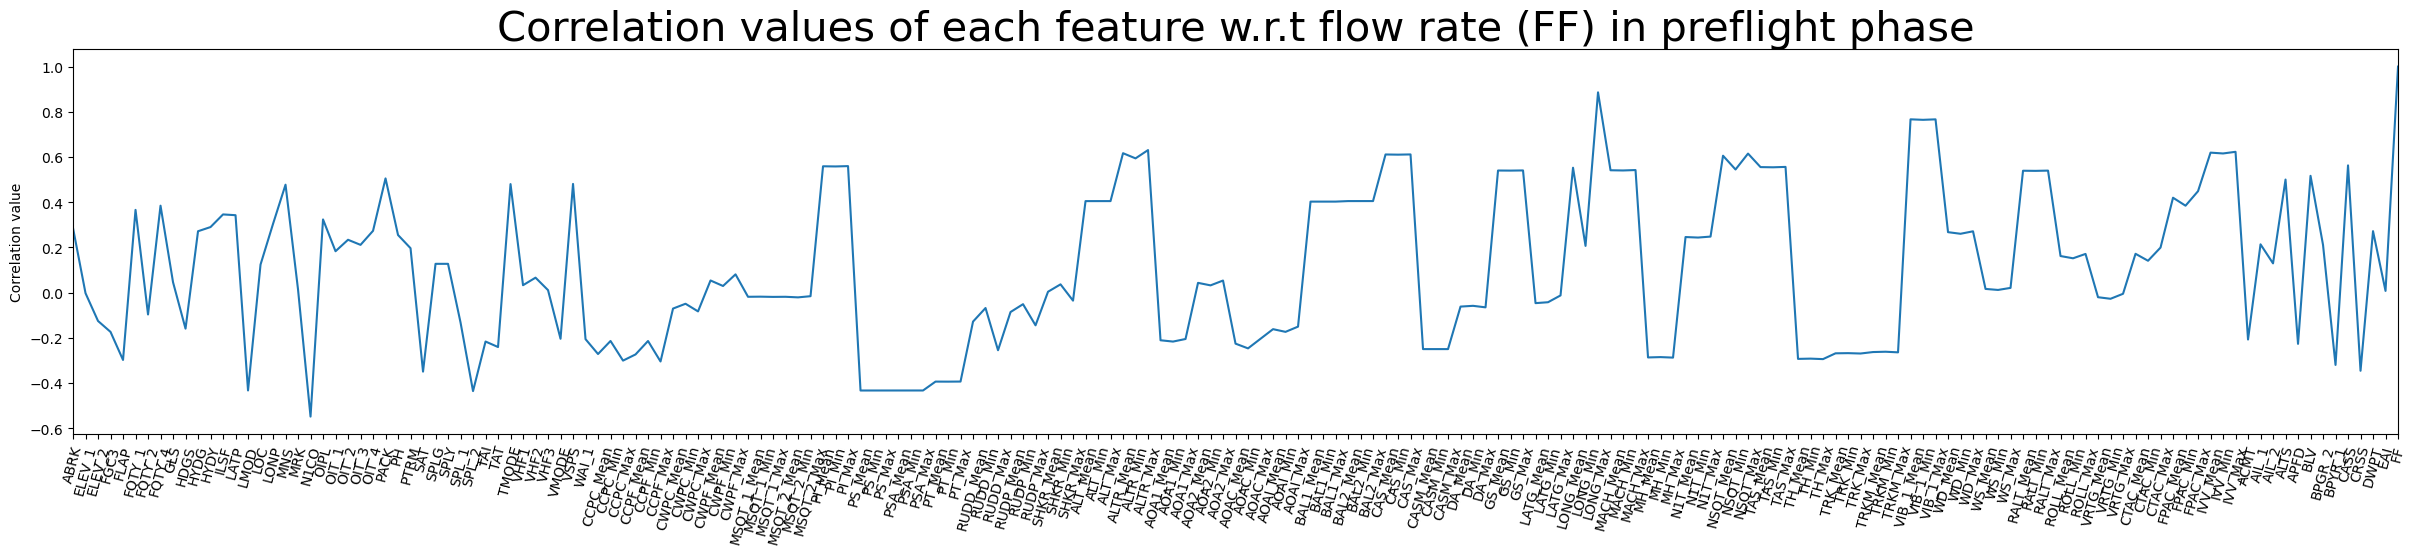

Positive Correlation value indicates direct relationship between two features while the negative correlation represents inverse relationship


In [70]:

plt.figure(figsize = (30,5))
plt.title("Correlation values of each feature w.r.t flow rate (FF) in preflight phase", fontsize = 30)
plt.plot(corr_values_with_FF)
plt.ylabel("Correlation value")
plt.margins(x=0)
plt.xticks(rotation = 75)
plt.show()

print("Positive Correlation value indicates direct relationship between two features while the negative correlation represents inverse relationship")

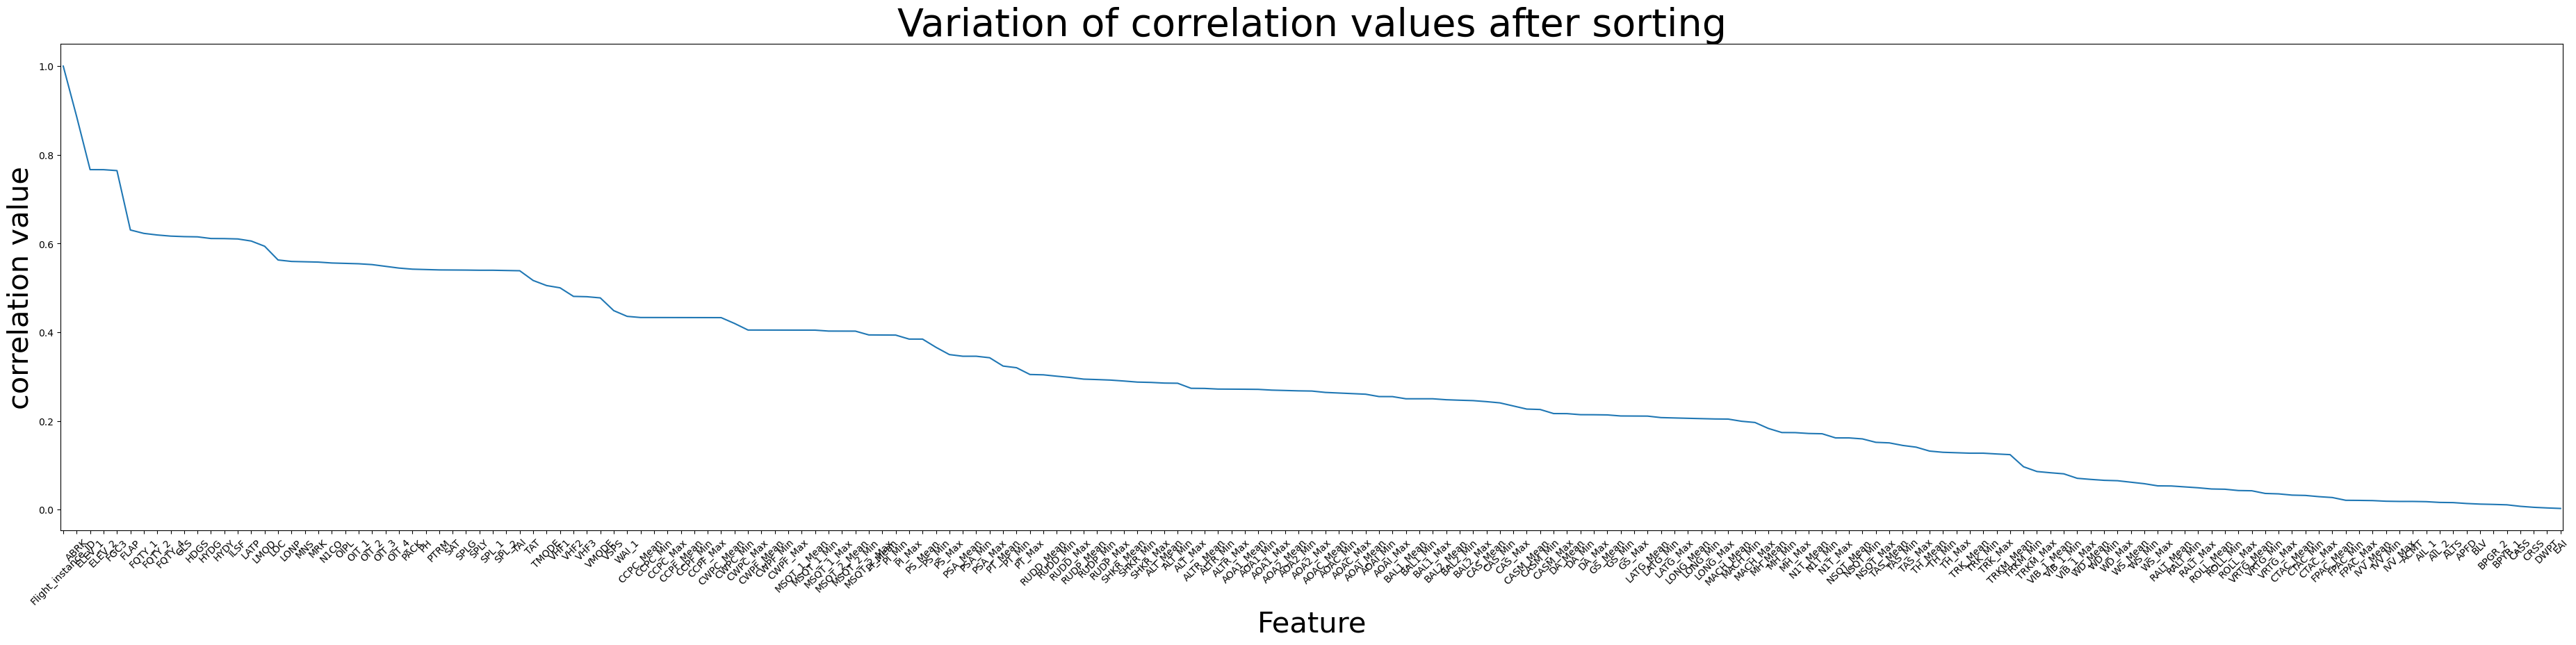

In [71]:

sorted_correlation_values = corr_values_with_FF.abs().sort_values(ascending = False)
plt.figure(figsize = (40,10))
plt.title("Variation of correlation values after sorting", fontsize = 40)
plt.plot(numeric_columns, sorted_correlation_values)
plt.xlabel("Feature", fontsize = 30)
plt.ylabel("correlation value", fontsize = 30)
plt.margins(x=0.001)
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.2)
plt.xticks(rotation=45)
plt.show()

In [72]:
print("Top 50 correlated features : ")
sorted_correlation_values.head(50)

Top 50 correlated features : 


FF            1.000000
LONG_Max      0.886059
VIB_1_Mean    0.766678
VIB_1_Max     0.766587
VIB_1_Min     0.764476
ALTR_Max      0.630589
IVV_Max       0.622919
IVV_Mean      0.619318
ALTR_Mean     0.616781
IVV_Min       0.615631
NSQT_Max      0.615112
CAS_Max       0.611376
CAS_Mean      0.611173
CAS_Min       0.610379
NSQT_Mean     0.605680
ALTR_Min      0.593940
CASS          0.562945
PI_Max        0.559657
PI_Mean       0.558927
PI_Min        0.558187
TAS_Max       0.556158
TAS_Mean      0.555291
TAS_Min       0.554432
LONG_Mean     0.552547
N1CO          0.548616
NSQT_Min      0.544712
MACH_Max      0.542256
MACH_Mean     0.541322
GS_Max        0.540553
MACH_Min      0.540399
GS_Mean       0.540177
GS_Min        0.539804
RALT_Max      0.539785
RALT_Mean     0.539235
RALT_Min      0.538669
BLV           0.516721
PACK          0.505263
ALTS          0.500197
VSPS          0.480883
TMODE         0.480129
MNS           0.477477
FPAC_Max      0.448749
SPL_2         0.435825
PS_Min     

# Combined Dataset analysis

Uses of analysing combined dataset : 

1. Fuel consumption is high or low in one particular phase

2. 


In [23]:
combined_df.head()

,Flight_instance_ID,Day,ABRK,ELEV_1,ELEV_2,EVNT,FADF,FADS,FGC3,FLAP,...,BPGR_2,BPYR_1,BPYR_2,CASS,CRSS,DFGS,DWPT,EAI,FF,Timestamp
0,676200408180742,18,83.890884,-0.595299,42.656948,1,15,15,120,95,...,19.5313,48.828247,0.0,131.0,-158.026213,1,27840,0,0,2004-08-18 07:41:36
1,676200408180742,18,83.876236,-0.574841,42.656948,1,15,15,120,95,...,19.5313,48.828247,0.0,131.0,-158.026213,1,27840,0,0,2004-08-18 07:41:37
2,676200408180742,18,83.876236,-0.574841,42.656948,1,15,15,120,94,...,19.5313,48.828247,0.0,131.0,-158.026213,1,27840,0,0,2004-08-18 07:41:38
3,676200408180742,18,83.876236,-0.595299,42.656948,1,15,15,120,94,...,19.5313,48.828247,0.0,131.0,-158.026213,1,27840,0,0,2004-08-18 07:41:39
4,676200408180742,18,83.876236,-0.595299,42.656948,1,15,15,120,94,...,19.5313,48.828247,0.0,131.0,-158.026213,1,27840,0,0,2004-08-18 07:41:40


In [24]:
combined_df.shape

(1074612, 208)

In [26]:
len(set_of_all_dataframes), combined_df.shape

(200, (1074612, 208))

In [27]:
combined_df.describe()

,Flight_instance_ID,Day,ABRK,ELEV_1,ELEV_2,EVNT,FADF,FADS,FGC3,FLAP,...,BPGR_1,BPGR_2,BPYR_1,BPYR_2,CASS,CRSS,DFGS,DWPT,EAI,FF
count,1.074612e+06,1.074612e+06,1.074612e+06,1.074612e+06,1.074612e+06,1.074612e+06,1.074612e+06,1.074612e+06,1.074612e+06,1.074612e+06,...,1.074612e+06,1.074612e+06,1.074612e+06,1.074612e+06,1.074612e+06,1.074612e+06,1.074612e+06,1.074612e+06,1.074612e+06,1.074612e+06
mean,6.762005e+14,1.602902e+01,1.120756e+02,-3.050079e+00,6.175390e+01,8.987504e-01,1.356509e+01,1.280215e+01,1.078913e+02,5.536887e+02,...,4.543803e-05,2.603129e+01,2.926743e+02,5.657034e-03,2.224098e+02,-1.210761e+01,9.096744e-01,6.136838e+04,2.397893e+00,4.132100e+03
std,1.950286e+08,6.498059e+00,1.985017e+01,1.947204e+01,1.849300e+01,3.016590e-01,4.409569e+00,4.787219e+00,2.306684e+02,1.015011e+03,...,4.265326e-02,1.718580e+01,8.272211e+02,1.430848e+00,6.792669e+01,1.020236e+02,2.866478e-01,1.008117e+05,5.231944e+00,2.491094e+03
min,6.762004e+14,1.000000e+00,6.000000e+01,-4.190000e+01,4.190000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.799987e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.762004e+14,1.200000e+01,1.199836e+02,-6.323540e+00,4.261603e+01,1.000000e+00,1.500000e+01,1.500000e+01,2.400000e+01,9.400000e+01,...,0.000000e+00,1.953130e+01,4.882825e+01,0.000000e+00,1.340000e+02,-8.806576e+01,1.000000e+00,9.280000e+03,0.000000e+00,1.542000e+03
50%,6.762004e+14,1.700000e+01,1.199836e+02,-3.152550e+00,5.982121e+01,1.000000e+00,1.500000e+01,1.500000e+01,2.400000e+01,9.400000e+01,...,0.000000e+00,2.929695e+01,5.371107e+01,0.000000e+00,2.522500e+02,-2.707011e+01,1.000000e+00,2.780000e+04,0.000000e+00,4.442000e+03
75%,6.762004e+14,2.000000e+01,1.199836e+02,1.511875e+00,8.238638e+01,1.000000e+00,1.500000e+01,1.500000e+01,1.200000e+02,9.500000e+01,...,0.000000e+00,3.417978e+01,5.371107e+01,0.000000e+00,2.800000e+02,8.296816e+01,1.000000e+00,6.063200e+04,0.000000e+00,5.522000e+03
max,6.762010e+14,3.100000e+01,1.199836e+02,3.995245e+01,1.034786e+02,1.000000e+00,1.500000e+01,1.500000e+01,2.042000e+03,3.672000e+03,...,4.394542e+01,3.032234e+03,1.851079e+04,4.052745e+02,3.000000e+02,1.789440e+02,1.000000e+00,7.068480e+05,1.500000e+01,1.236400e+04


In [28]:
combined_df['Timestamp'].min(), combined_df['Timestamp'].max()

(Timestamp('2002-03-04 06:48:36'), Timestamp('2004-08-26 00:47:01'))

So, we have flights data from 2002 to 2004. 

In [29]:
print("No.of flights the data is availabe for : ", len(combined_df['Flight_instance_ID'].unique()))

No.of flights the data is availabe for :  200


In [30]:
print([key for key in combined_df.keys()])

['Flight_instance_ID', 'Day', 'ABRK', 'ELEV_1', 'ELEV_2', 'EVNT', 'FADF', 'FADS', 'FGC3', 'FLAP', 'FQTY_1', 'FQTY_2', 'FQTY_4', 'GLS', 'GPWS', 'HDGS', 'HF1', 'HF2', 'HYDG', 'HYDY', 'ILSF', 'LATP', 'LMOD', 'LOC', 'LONP', 'MNS', 'MRK', 'MW', 'N1CO', 'OIPL', 'OIT_1', 'OIT_2', 'OIT_3', 'OIT_4', 'PACK', 'PH', 'PTRM', 'PUSH', 'SAT', 'SMKB', 'SNAP', 'SPLG', 'SPLY', 'SPL_1', 'SPL_2', 'TAI', 'TAT', 'TCAS', 'TMAG', 'TMODE', 'VHF1', 'VHF2', 'VHF3', 'VMODE', 'VSPS', 'WAI_1', 'CCPC_Mean', 'CCPC_Min', 'CCPC_Max', 'CCPF_Mean', 'CCPF_Min', 'CCPF_Max', 'CWPC_Mean', 'CWPC_Min', 'CWPC_Max', 'CWPF_Mean', 'CWPF_Min', 'CWPF_Max', 'MSQT_1_Mean', 'MSQT_1_Min', 'MSQT_1_Max', 'MSQT_2_Mean', 'MSQT_2_Min', 'MSQT_2_Max', 'PI_Mean', 'PI_Min', 'PI_Max', 'PS_Mean', 'PS_Min', 'PS_Max', 'PSA_Mean', 'PSA_Min', 'PSA_Max', 'PT_Mean', 'PT_Min', 'PT_Max', 'RUDD_Mean', 'RUDD_Min', 'RUDD_Max', 'RUDP_Mean', 'RUDP_Min', 'RUDP_Max', 'SHKR_Mean', 'SHKR_Min', 'SHKR_Max', 'TOCW_Mean', 'TOCW_Max', 'ALT_Mean', 'ALT_Min', 'ALT_Max', '

In [31]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074612 entries, 0 to 1074611
Columns: 208 entries, Flight_instance_ID to Timestamp
dtypes: datetime64[ns](1), float64(129), int64(78)
memory usage: 1.7 GB


In [32]:
combined_df['PH'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1074612 entries, 0 to 1074611
Series name: PH
Non-Null Count    Dtype
--------------    -----
1074612 non-null  int64
dtypes: int64(1)
memory usage: 8.2 MB


In [34]:
combined_df_unknown     =  combined_df[combined_df['PH']==0] 
combined_df_preflight   =  combined_df[combined_df['PH']==1]
combined_df_taxi        =  combined_df[combined_df['PH']==2]
combined_df_takeoff     =  combined_df[combined_df['PH']==3]
combined_df_climb       =  combined_df[combined_df['PH']==4]
combined_df_cruise      =  combined_df[combined_df['PH']==5]
combined_df_approach    =  combined_df[combined_df['PH']==6]
combined_df_rollout     =  combined_df[combined_df['PH']==7]

In [40]:
dfs = [combined_df_unknown, combined_df_preflight, combined_df_taxi, combined_df_takeoff, combined_df_climb, combined_df_cruise, combined_df_approach, combined_df_rollout]
for i,d in enumerate(dfs):
    print(f"{phases[i] :<10} : {d.shape}")

unknown    : (102604, 208)
preflight  : (9188, 208)
taxi       : (236211, 208)
takeoff    : (15327, 208)
climb      : (209177, 208)
cruise     : (273730, 208)
approach   : (224081, 208)
rollout    : (4294, 208)


In [41]:
ph_value_counts = combined_df['PH'].value_counts()
ph_value_counts = ph_value_counts.sort_index()
print("No.of total data points available in each phase")
for i in range(1, len(ph_value_counts)):
    print(f"{phase_encodings[i]:<10} : {ph_value_counts[i]}")

No.of total data points available in each phase
preflight  : 9188
taxi       : 236211
takeoff    : 15327
climb      : 209177
cruise     : 273730
approach   : 224081
rollout    : 4294


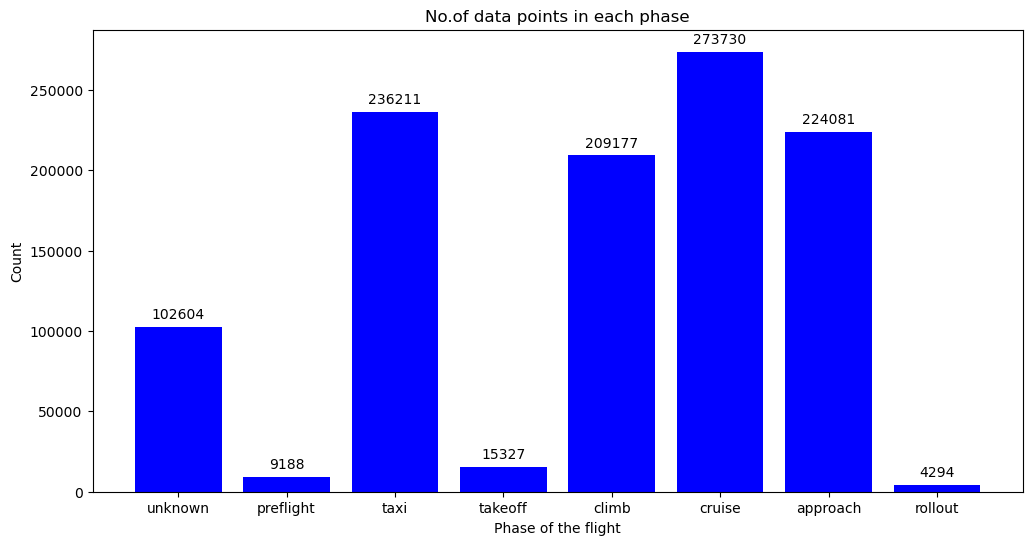

In [43]:
plt.figure(figsize=(12,6))
ax = plt.bar(phases, ph_value_counts, color = 'blue')

plt.xlabel('Phase of the flight')
plt.ylabel('Count')
plt.title('No.of data points in each phase')


for index, value in enumerate(ph_value_counts):
    plt.annotate(value, (index, value), textcoords="offset points", xytext=(0, 6), ha='center')

plt.show()

Why taxi data points are more in number ? 

# Phase wise dataset analysis

## Preflight analysis

#### Lets now clearly observe the Preflight phase of aircract

PH = 1  
Lets consider only the first flight instance (i=0) and see how the values are correlated . 

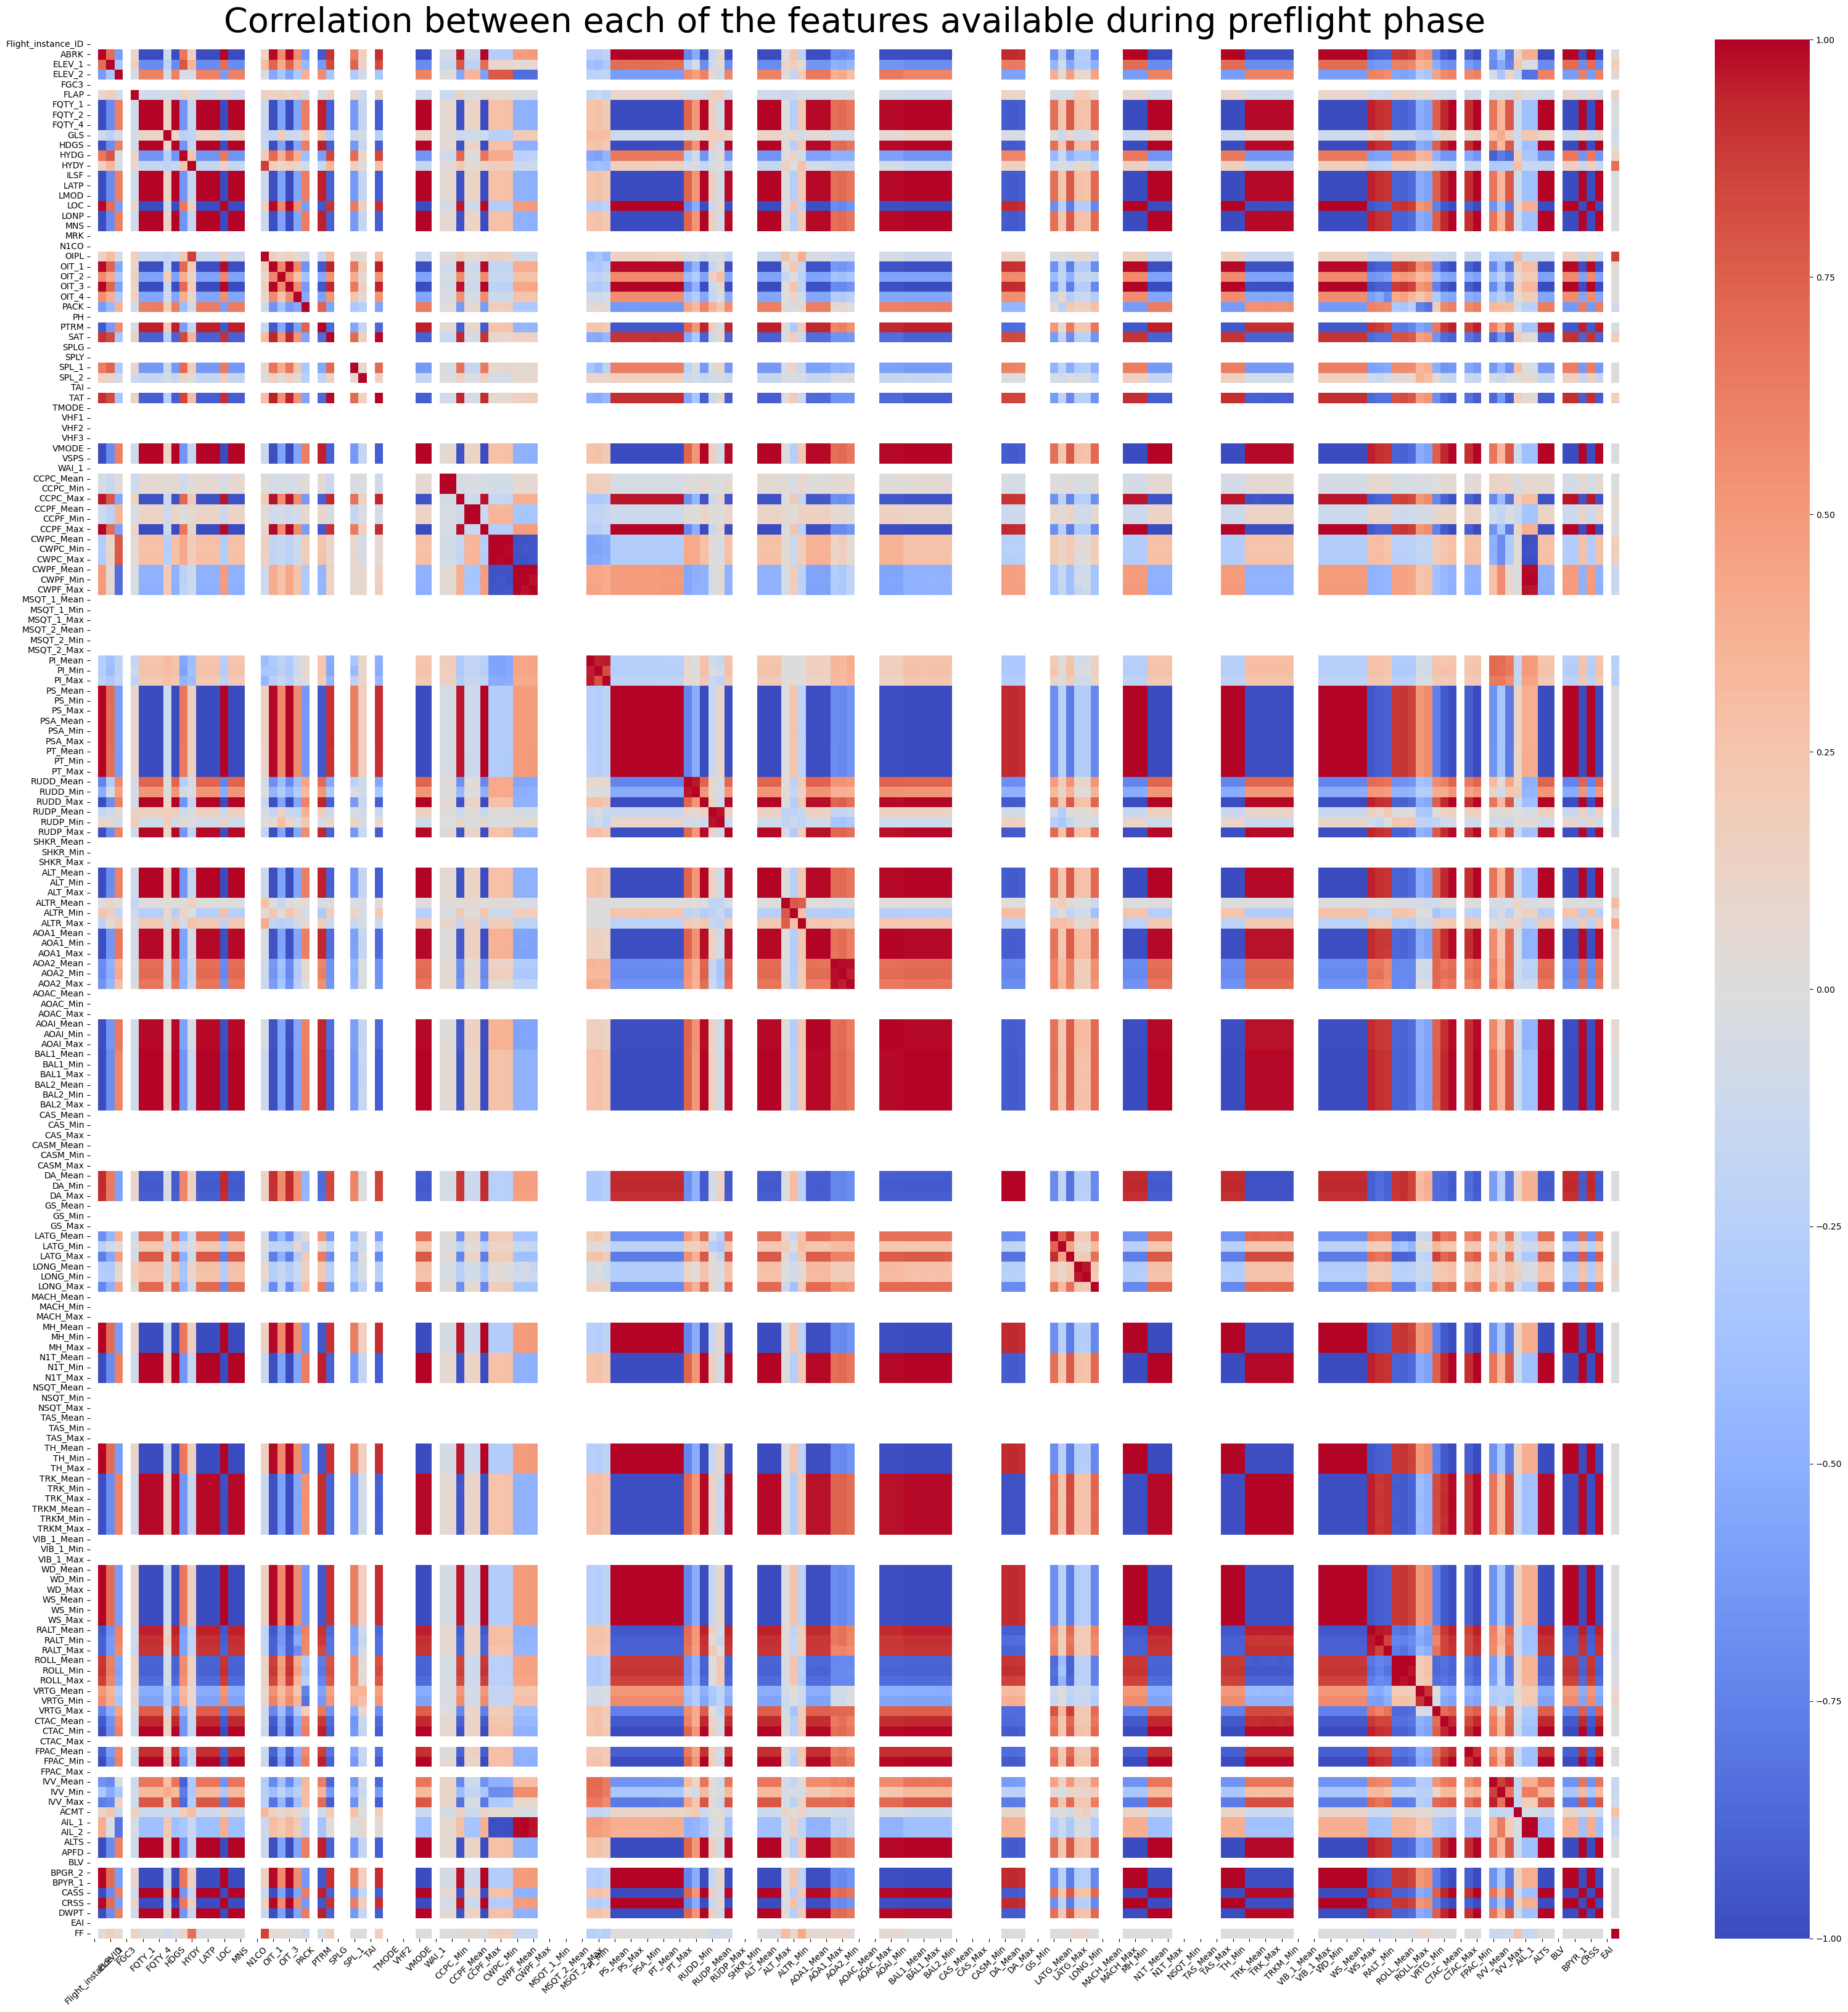

In [67]:
numeric_columns_dataset = first_instance_preflight.select_dtypes(include = 'number')
numeric_columns = numeric_columns_dataset.columns
corr_matrix = numeric_columns_dataset.corr()
plt.figure(figsize=(40,40))
sns.heatmap(corr_matrix, cmap = 'coolwarm')
plt.title("Correlation between each of the features available during preflight phase", fontsize = 40)
plt.xticks(rotation=45)
plt.show()

white color indicated that there is no correlation at all between the respective features in x axis and y axis 

It can be observed that there many features are correlated to each other. 

Orange - Positively correlated  
blue - negative correlated

Lets observe the correlation values w.r.t Fuel flow rate

In [57]:
corr_values_with_FF = corr_matrix['FF']
corr_values_with_FF.values  

array([            nan,  1.36116126e-02,  1.86300282e-01,  5.48699141e-02,
                   nan,  1.40907031e-01, -1.33292336e-02, -1.35273881e-02,
       -1.34491153e-02, -9.75629839e-02, -1.33739668e-02,  1.13451650e-01,
        6.93192112e-01, -1.33739668e-02, -1.33719118e-02, -1.33739668e-02,
        1.22248648e-02, -1.33513357e-02, -1.33739668e-02,             nan,
                   nan,  8.51787069e-01,  5.84596197e-02,  4.13223294e-02,
        2.86457759e-02,  4.24556739e-02, -1.04058927e-01,             nan,
       -3.92227036e-02,  1.65231441e-01,             nan,             nan,
        1.26666346e-02,  2.61602034e-02,             nan,  1.56252795e-01,
                   nan,             nan,             nan,             nan,
       -1.33739668e-02, -1.33739668e-02,             nan, -1.46345782e-02,
       -1.50615514e-02,  5.44811305e-02,  5.22297438e-02,  5.24275698e-02,
       -2.07551306e-02,  1.61235051e-01,  1.64801523e-01,  1.56571336e-01,
       -1.42571219e-01, -

Why nan values in the correlation ? 

We can say there are many features that are not related with flow rate during preflight phase of flight

In [66]:
no_of_null_values = first_instance_preflight.isnull().sum().sum()
print("no.of null values present : ", no_of_null_values)

no.of null values present :  0


In [48]:
first_instance_preflight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 0 to 7079
Columns: 189 entries, Flight_instance_ID to Timestamp
dtypes: datetime64[ns](1), float64(126), int64(62)
memory usage: 138.0 KB


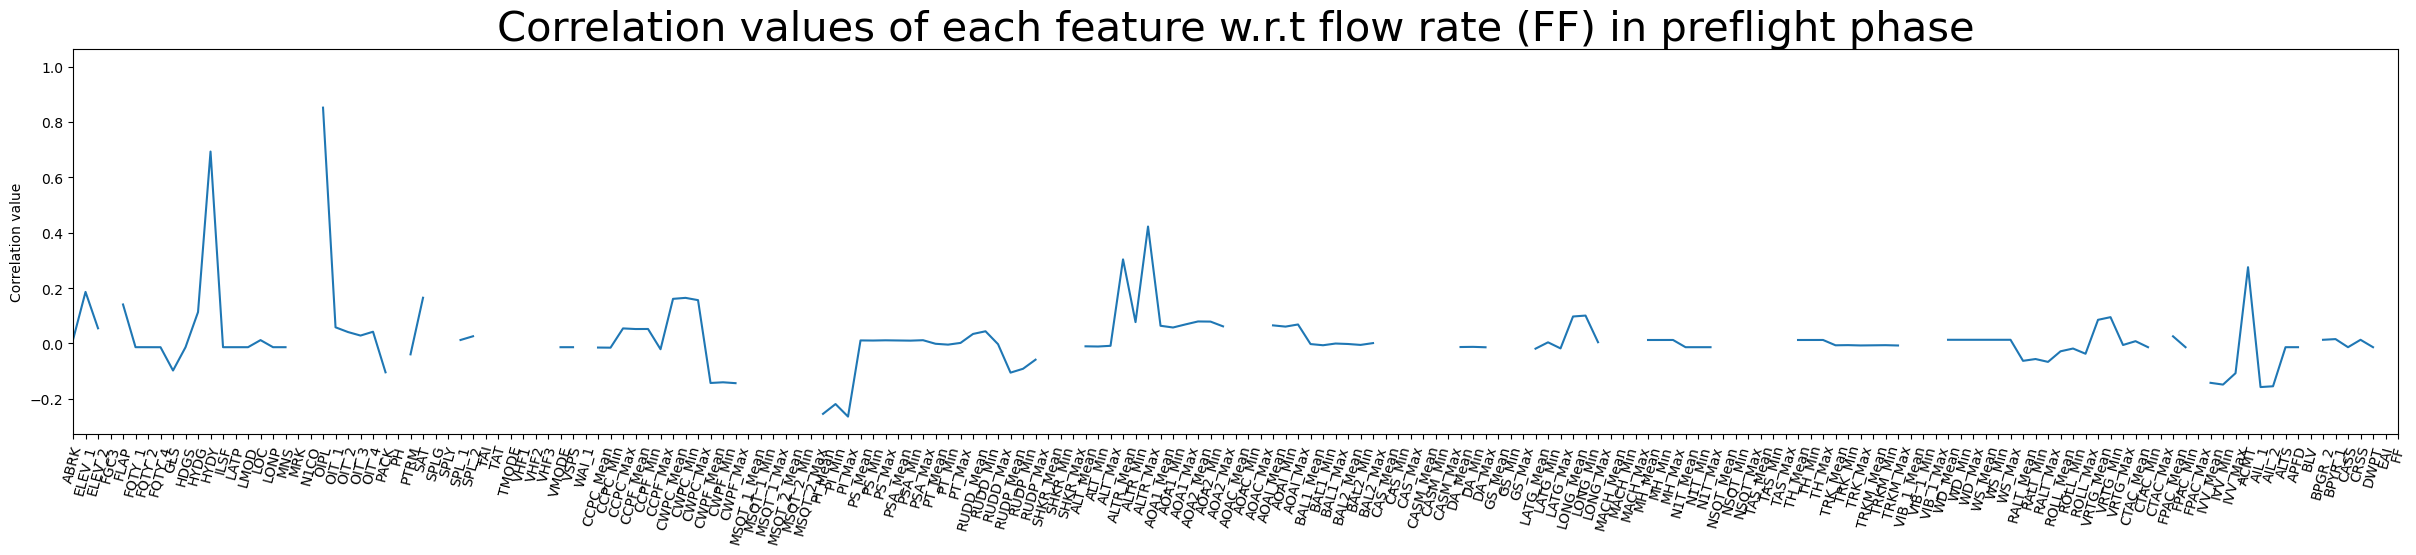

Positive Correlation value indicates direct relationship between two features while the negative correlation represents inverse relationship


In [46]:

plt.figure(figsize = (30,5))
plt.title("Correlation values of each feature w.r.t flow rate (FF) in preflight phase", fontsize = 30)
plt.plot(corr_values_with_FF)
plt.ylabel("Correlation value")
plt.margins(x=0)
plt.xticks(rotation = 75)
plt.show()

print("Positive Correlation value indicates direct relationship between two features while the negative correlation represents inverse relationship")

Lets find out the top 50 correlated features and their values w.r.t Flow rate (FF)

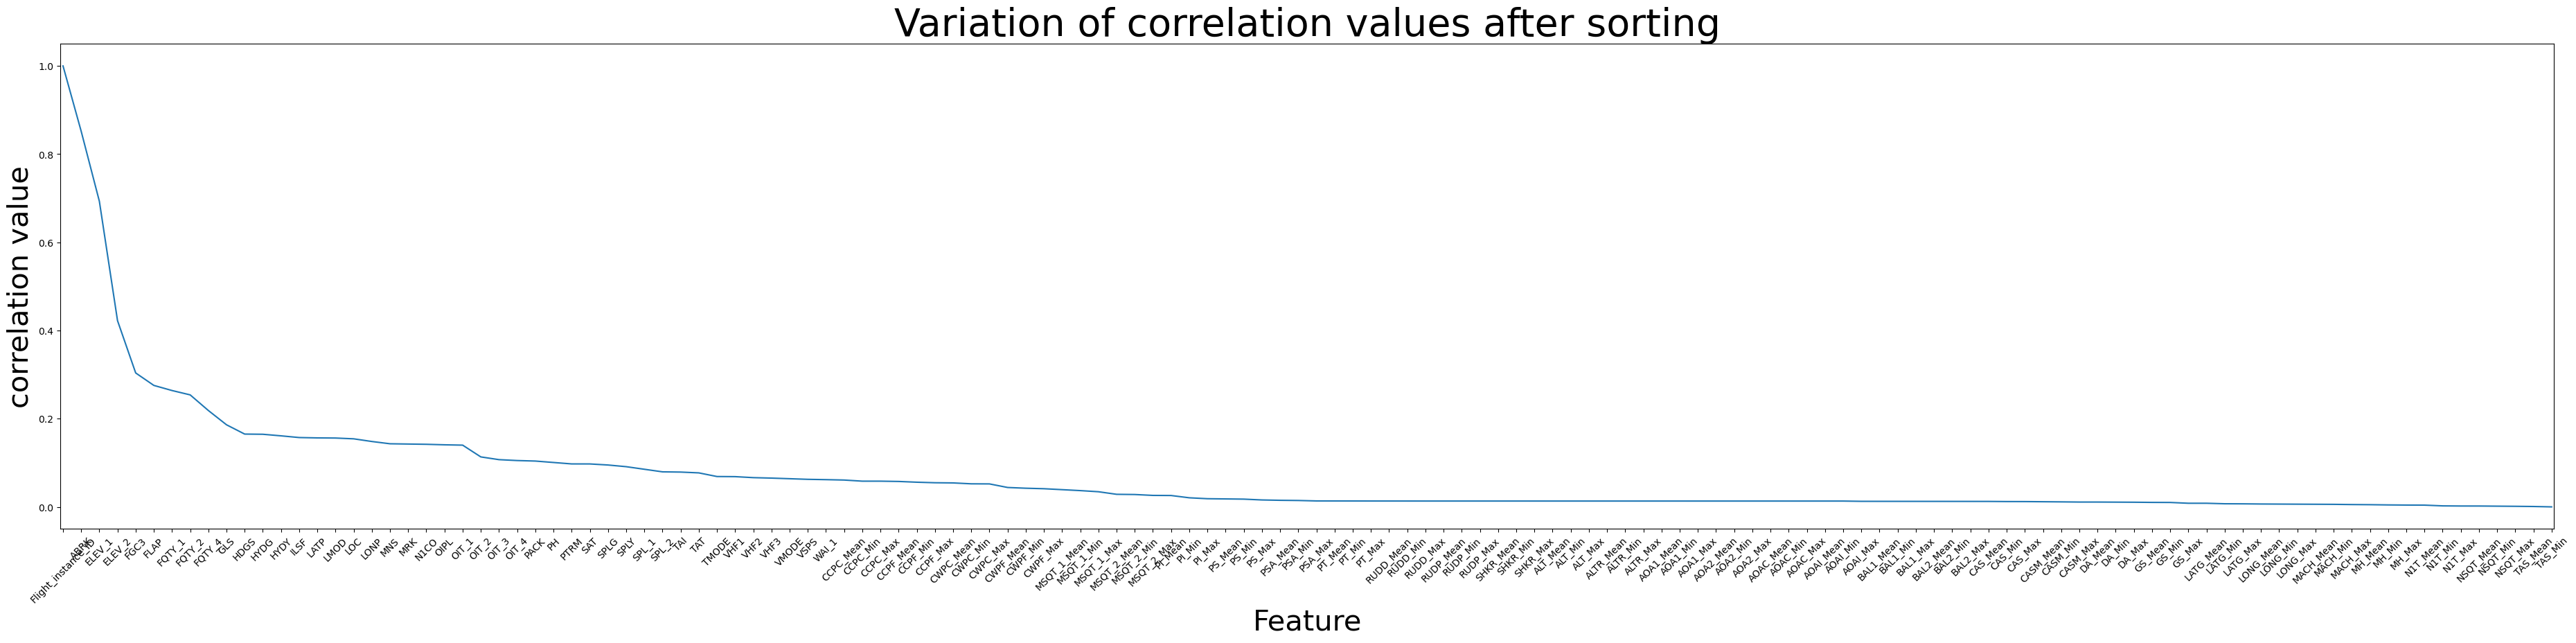

In [64]:
sorted_correlation_values = corr_values_with_FF.abs().sort_values(ascending = False)
plt.figure(figsize = (40,10))
plt.title("Variation of correlation values after sorting", fontsize = 40)
plt.plot(numeric_columns, sorted_correlation_values)
plt.xlabel("Feature", fontsize = 30)
plt.ylabel("correlation value", fontsize = 30)
plt.margins(x=0.001)
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.2)
plt.xticks(rotation=45)
plt.show()

In [65]:
print("Top 50 correlated features : ")
sorted_correlation_values.head(50)

Top 50 correlated features : 


FF           1.000000
OIPL         0.851787
HYDY         0.693192
ALTR_Max     0.422411
ALTR_Mean    0.303841
ACMT         0.275578
PI_Max       0.263999
PI_Mean      0.254098
PI_Min       0.218709
ELEV_1       0.186300
SAT          0.165231
CWPC_Min     0.164802
CWPC_Mean    0.161235
AIL_1        0.157361
CWPC_Max     0.156571
TAT          0.156253
AIL_2        0.154474
IVV_Min      0.148419
CWPF_Max     0.143250
CWPF_Mean    0.142571
IVV_Mean     0.142053
FLAP         0.140907
CWPF_Min     0.140119
HYDG         0.113452
IVV_Max      0.107246
RUDP_Mean    0.105225
PACK         0.104059
LONG_Min     0.100828
GLS          0.097563
LONG_Mean    0.097515
VRTG_Min     0.095106
RUDP_Min     0.091307
VRTG_Mean    0.085471
AOA2_Mean    0.079608
AOA2_Min     0.079064
ALTR_Min     0.077255
AOA1_Max     0.068981
AOAI_Max     0.068709
RALT_Max     0.066441
AOAI_Mean    0.065406
AOA1_Mean    0.063966
RALT_Mean    0.062616
AOA2_Max     0.061901
AOAI_Min     0.061004
OIT_1        0.058460
RUDP_Max  

Lets find out the correlation values in all flight instances and then find the average of all correlation which gives correct measure of feature's relationship with flow rate (FF)

In [ ]:
no_of_instances = len(set_of_all_flight_dataframes)
no_of_features = len(combined_df.drop(columns = 'Flight_instance_ID').columns.values)
no_of_instances, no_of_features

We want to get the average correlation values w.r.t the FF (flow rate)

In [ ]:
set_of_all_flight_dataframes[1].corr()['FF'] #+ set_of_all_flight_dataframes[1].corr()['FF']

In [ ]:
avg_correlation_values = np.zeros(no_of_instances)

for df in set_of_all_flight_dataframes:
    corr_values = np.df.corr()['FF']

## Taxi analysis

## Takeoff analysis

## Climb analysis

## Cruise analysis

## Approach analysis

## Rollout analysis